# Tips Prediction #

In this library, we will explore the data which we retrieved from *LifeProTips*, *ShittyLifeProTips*, *UnethicalLifeProTips* and *IllegalLifeProTips*.
Afterwards, we will make some predictions to determine which subreddit a certain post belongs to.

In [1]:
# Import everything in case we just want to run particular cells
import json
import math
import pandas as pd
import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load and split ##

Let's start by loading the posts into memory

In [2]:
import json

posts = {}

# Import LifeProTips
with open('tips/lifeprotips_dump_1.json', 'r') as lptf:
    posts['lpt'] = json.load(lptf)

# Import ShittyLifeProTips
with open('tips/shittylifeprotips_dump_1.json', 'r') as slptf:
    posts['slpt'] = json.load(slptf)
    
# Import UnethicalLifeProTips
with open('tips/unethicallifeprotips_dump_1.json', 'r') as ulptf:
    posts['ulpt'] = json.load(ulptf)

# Import IllegalLifeProTips
with open('tips/illegallifeprotips_dump_1.json', 'r') as ilptf:
    posts['ilpt'] = json.load(ilptf)

Let's remove any duplicate from the posts

In [3]:
for subreddit in posts:
    obs_ids = [] # observed ids
    unique_posts = [] # unique posts
    for post in posts[subreddit]: # every post is a dictionary
        if post['id'] not in obs_ids:
            obs_ids.append(post['id'])
            unique_posts.append(post)
    posts[subreddit] = unique_posts

Check the amount of unique posts we retrieved per subreddit $\rightarrow$ No duplicates!

In [4]:
for (s, a) in posts.items():
    print('{} posts retrieved from {}'.format(len(a), s))

30000 posts retrieved from lpt
30000 posts retrieved from slpt
30000 posts retrieved from ulpt
10000 posts retrieved from ilpt


The reason why there are only 10k posts from *IllegalLifeProTips* is because the community is relatively young compared to the rest of subreddits. It was founded a year ago while the other three appeared 7 years ago.

---

Now, let's shuffle the posts for each subreddit to perform an arbitrary and even train/validation/test division

In [5]:
import random

for (s, p) in posts.items():
    random.shuffle(p)

We will perfom a train/validation/test split as follows:
* $4/9$ for training ($2/3$ of $2/3$)
* $2/9$ for validation ($1/3$ of $2/3$)
* $1/3$ for testing

In [6]:
import math

# Create and empty dictionary to store train, validation and test posts
posts_struct = {'train':[], 'validation':[], 'test':[]}

# For each subreddit, split
for p in posts.values():
    # p is the list of posts (each post is a dictionary)
    # train + validation is 2/3; test is 1/3
    split_index = int(math.ceil((2/3)*len(p)))
    p_trainval = p[:split_index]
    p_test = p[split_index:]
    # Now, out of train+validation, 2/3 go to train and 1/3 to validation
    split_index = int(math.ceil((2/3)*len(p_trainval)))
    p_train = p_trainval[:split_index]
    p_validation = p_trainval[split_index:]
    
    # Finally, add the posts to their respective parts in the posts_struct dictionary
    posts_struct['train'].extend(p_train)
    posts_struct['validation'].extend(p_validation)
    posts_struct['test'].extend(p_test)

# Shuffle the lists
for (sep, p) in posts_struct.items():
    random.shuffle(p)

Check that we performed a correct split

In [7]:
ins_tot = len(posts_struct['train']) + len(posts_struct['validation']) + len(posts_struct['test'])
print('Total number of instances: {}'.format(ins_tot))
print('Percentage of train instances: {}'.format((len(posts_struct['train'])/ins_tot)*100))
print('Percentage of validation instances: {}'.format((len(posts_struct['validation'])/ins_tot)*100))
print('Percentage of test instances: {}'.format((len(posts_struct['test'])/ins_tot)*100))

Total number of instances: 100000
Percentage of train instances: 44.446999999999996
Percentage of validation instances: 22.220000000000002
Percentage of test instances: 33.333


We just need one more step to perform. Creating `pandas` DataFrames for training, validation and testing will make data handling easier

In [8]:
import pandas as pd

# DataFrame for training
df_train = pd.DataFrame({'instance':[s['title'] for s in posts_struct['train']],
                         'label':[s['label'] for s in posts_struct['train']]})

# DataFrame for validation
df_validation = pd.DataFrame({'instance':[s['title'] for s in posts_struct['validation']],
                              'label':[s['label'] for s in posts_struct['validation']]})

# DataFrame for testing
df_test = pd.DataFrame({'instance':[s['title'] for s in posts_struct['test']],
                        'label':[s['label'] for s in posts_struct['test']]})

## 2. Instance pre-processing ##

Define a method to clean the instances<br>
**Disclaimer:** we are **not** copying this from Assignment 2

In [9]:
def clean(text, stem_words=True):
    
    # Empty question
    if type(text) != str or text=='':
        return ''
    
    # Make text lowercase
    text = text.lower()

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub("\'t'", " not ", text)
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub(" thats ", " that is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("-", " ", text)
    #you might need more
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    # remove punctuation
    for c in punctuation:
        text = re.sub("\\" + c, "", text)
        
    # split text
    n_text = text.split();
    
    # remove stopwords and subreddit keywords
    stops = set(['the', 'to', 'now', 'should', 'just', 'very', 'too', 'again', 'in', 'out', 'on',
                 'over', 'at', 'of', 'about'])
    #stops = set(stopwords.words('english'))
    sub_kwords = set(['lpt', 'ulpt', 'ilpt', 'slpt'])
    numbers = set(['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve'])
    n_text = [word for word in n_text if word not in stops|sub_kwords|numbers if word.isalpha()]
    
    # Change numbers and other similar words
    #subs = [('one', '1'), ('ii', '2'), ('two', '2'), ('iii', '3'), ('three', '3'), ('iv', '4'), ('four', '4'),
    #        ('v', '5'), ('five', '5'), ('vi', '6'), ('six', '6'), ('vii', '7'), ('seven', '7'), ('viii', '8'),
    #        ('eight', '8'), ('ix', '9'), ('nine', '9'), ('ten', '10'), ('eleven', '11'), ('twelve', '12')]
    #for i, word in enumerate(n_text):
    #    for (bad, good) in subs:
    #        if word == bad:
    #            n_text[i] = good
    #            break
    
    # Return a list of words
    return ' '.join(n_text)

Clean the DataFrames

In [10]:
df_train['instance'] = df_train['instance'].apply(clean)
df_validation['instance'] = df_validation['instance'].apply(clean)
df_test['instance'] = df_test['instance'].apply(clean)

# Drop empty posts
df_train = df_train[df_train['instance'] != ""]
df_train = df_train[df_train['instance'] != " "]
df_validation = df_validation[df_validation['instance'] != ""]
df_validation = df_validation[df_validation['instance'] != " "]
df_test = df_test[df_test['instance'] != ""]
df_test = df_test[df_test['instance'] != " "]

## 3. Train the ML Models ##

### BOW + Naive Bayes ###

First, build the BOW representation for training, validation and testing

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# Generate the vocabulary using all instances
vectorizer.fit(np.concatenate((df_train['instance'].values, df_validation['instance'].values,
                               df_test['instance'].values), axis=0))

# Transform each batch separately and add labels
# Train
x_train = vectorizer.transform(df_train['instance'].values).toarray()
y_train = df_train['label'].values
# Validation
x_validation = vectorizer.transform(df_validation['instance'].values).toarray()
y_validation = df_validation['label'].values
# Train+Validation
x_tv = np.concatenate((x_train, x_validation), axis=0)
y_tv = np.concatenate((y_train, y_validation), axis=0)
# Test
x_test = vectorizer.transform(df_test['instance'].values).toarray()
y_test = df_test['label'].values

Perform validation using `MultinomialNB` from `sklearn`

In [12]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB

alphas = np.linspace(0.3,0.8,10)
accs = []
precs = []
recs = []
fscores = []

top_acc = 0
top_alpha = 0
for alpha in alphas:
    model = MultinomialNB(alpha)
    model.fit(x_train, y_train)
    acc = model.score(x_validation, y_validation)
    accs.append(acc)
    measures = precision_recall_fscore_support(y_validation, model.predict(x_validation), average='macro')
    precs.append(measures[0])
    recs.append(measures[1])
    fscores.append(measures[2])
    if acc > top_acc:
        top_acc = acc
        top_alpha = alpha
print("Top accuracy:", top_acc)
print("Alpha:", top_alpha)

# Retrain with whole training set and optimal alpha
top_model = MultinomialNB(top_alpha)
top_model.fit(x_tv, y_tv);

Top accuracy: 0.6169241890304509
Alpha: 0.5777777777777777


Plot measures vs alpha

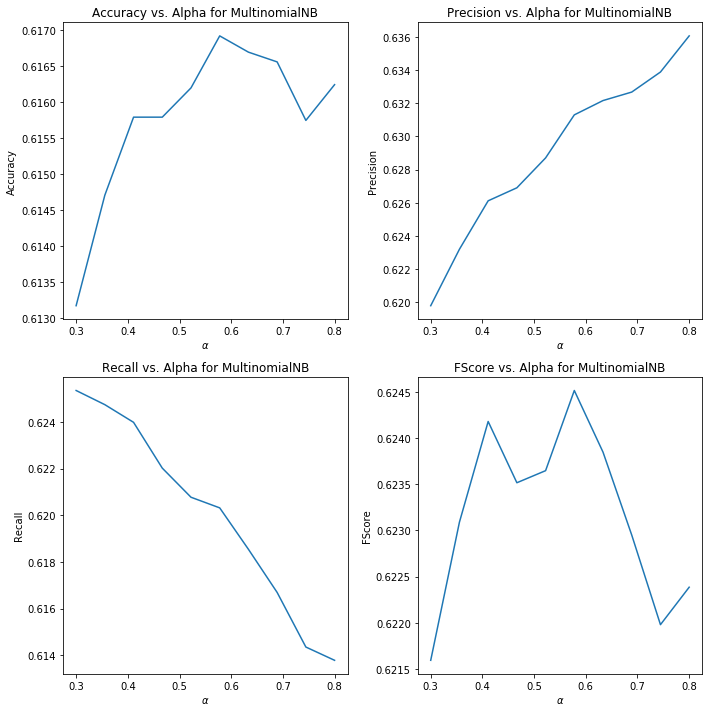

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Accuracy vs alpha
axes[0][0].plot(alphas, accs, lw=1.5)
axes[0][0].set_xlabel(r'$\alpha$')
axes[0][0].set_ylabel('Accuracy')
axes[0][0].set_title('Accuracy vs. Alpha for MultinomialNB')

# Precision vs alpha
axes[0][1].plot(alphas, precs, lw=1.5)
axes[0][1].set_xlabel(r'$\alpha$')
axes[0][1].set_ylabel('Precision')
axes[0][1].set_title('Precision vs. Alpha for MultinomialNB')

# Recall vs alpha
axes[1][0].plot(alphas, recs, lw=1.5)
axes[1][0].set_xlabel(r'$\alpha$')
axes[1][0].set_ylabel('Recall')
axes[1][0].set_title('Recall vs. Alpha for MultinomialNB')

# FScore vs alpha
axes[1][1].plot(alphas, fscores, lw=1.5)
axes[1][1].set_xlabel(r'$\alpha$')
axes[1][1].set_ylabel('FScore')
axes[1][1].set_title('FScore vs. Alpha for MultinomialNB')

# Adjust layout
fig.tight_layout()

Check for accuracy on test set

In [14]:
print("MN Accuracy: %0.2f%%" % (100 * top_model.score(x_test, y_test)))

MN Accuracy: 62.70%


Compute confusion matrix, precision, recall and F-score with micro and macro averaging

In [15]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, top_model.predict(x_test))

measures_macro = list(precision_recall_fscore_support(y_test, top_model.predict(x_test), average='macro'))[:-1]
measures_micro = list(precision_recall_fscore_support(y_test, top_model.predict(x_test), average='micro'))[:-1]

Show confusion matrix

In [16]:
cf_df = pd.DataFrame(cf, columns=['Predicted ilpt', 'Predicted lpt', 'Predicted slpt', 'Predicted ulpt'])
cf_df.rename(index={0:'ilpt',1:'lpt',2:'slpt',3:'ulpt'}, inplace=True)
cf_df

,Predicted ilpt,Predicted lpt,Predicted slpt,Predicted ulpt
ilpt,2280,124,213,704
lpt,347,6041,1871,1715
slpt,198,1563,6059,2122
ulpt,607,1085,1840,6443


Show precision, recall and F-score with averaging

In [17]:
measures_macro = ['macro'] + measures_macro
measures_micro = ['micro'] + measures_micro
measures_df = pd.DataFrame([measures_macro, measures_micro], columns=['Averaging', 'Precision', 'Recall', 'FScore'])
measures_df

,Averaging,Precision,Recall,FScore
0,macro,0.635828,0.636891,0.635340
1,micro,0.626972,0.626972,0.626972


### Word2Vec ###

We will train a `Word2Vec` model from `gensim` using our entire corpus.

First, we define a function to tokenize a list of strings

In [18]:
def tokenize_arr(sentences):
    """Given a list of sentences, return the list with the tokenized strings (a list itself)."""
    new_sentences = sentences.copy()
    for i, sentence in enumerate(new_sentences):
        new_sentences[i] = sentence.split()
    return new_sentences

Generate the `sentences` for `Word2Vec` using all corpus

In [19]:
sentences = tokenize_arr(np.concatenate((df_train['instance'].values,
                                         df_validation['instance'].values,
                                         df_test['instance'].values), axis=0))

Train `Word2Vec` using `sentences`.<br>
We must look for good parameter values regarding `min_count`, `size` and `window`.

In [20]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences, min_count=1, size=200, window=10)

Embeddings must be generated for the instances in `df_train`, `df_validation` and `df_test`

In [21]:
# Tokenize the submissions in train, validation and test
sub_train = tokenize_arr(df_train['instance'].values)
sub_validation = tokenize_arr(df_validation['instance'].values)
sub_test = tokenize_arr(df_test['instance'].values)

Let's define a method to transform a list of tokens into an embedding

In [22]:
def sum_lists(lol):
    """Given a list of lists of equal size, sum its elements (like vector sum) and take the average."""
    result = []
    for element in lol[0]: # Create the size of sum array
        result.append(0)
    for l in lol: # For every sublist
        for i, c in enumerate(l): # For every element
            result[i] += c
    # Average the sum
    for i, v in enumerate(result):
        result[i] /= len(lol);
    return result

In [23]:
def sen2emb(sentence, word_dict):
    """Transform a tokenized sentence into an embedding by adding the embedding word vectors."""
    embeddings = []
    for token in sentence:
        if token in word_dict.vocab:
            embeddings.append(word_dict[token].tolist())
    embedding = sum_lists(embeddings)
    return embedding

Generate $x$ for training, validation and testing

In [24]:
x_train = [sen2emb(sub, w2v_model.wv) for sub in sub_train]
x_validation = [sen2emb(sub, w2v_model.wv) for sub in sub_validation]
x_tv = np.concatenate((x_train, x_validation), axis=0)
x_test = [sen2emb(sub, w2v_model.wv) for sub in sub_test]

Generate the labels for training, validation and testing

In [25]:
y_train = df_train['label'].values
y_validation = df_validation['label'].values
y_tv = np.concatenate((y_train, y_validation), axis=0)
y_test = df_test['label'].values

Perform **feature standarization** so that the values of each feature in the data have zero-mean and unit-variance.

$$x'=\frac{x-\overline{x}}{\sigma}$$

Where $x$ is the original feature vector, $\overline{x} = average(x)$ is the mean of that feature vector, $\sigma$ is its standard deviation.

In [26]:
def standarize(lol):
    """Given a list of list, standarize the sublists."""
    lol_np = np.array(lol)
    avg_v = np.mean(lol_np, axis=0)
    std_v = np.std(lol_np, axis=0)
    return (lol_np - avg_v) / std_v

Standarize $x$ for training, validation and testing

In [27]:
x_train = standarize(x_train)
x_validation = standarize(x_validation)
x_tv = standarize(x_tv)
x_test = standarize(x_test)

#### Support Vector Machine ####

Tune hyperparameters and retrieve measures

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

top_accuracy = 0;
top_reg = 0;

regs = np.linspace(1e-10, 1, 10)
accs = []
precs = []
recs = []
fscores = []

for reg in regs:
    svm_model = SVC(gamma='scale', C=reg)
    svm_model.fit(x_train, y_train)
    acc = svm_model.score(x_validation, y_validation)
    accs.append(acc)
    measures = precision_recall_fscore_support(y_validation, svm_model.predict(x_validation), average='macro')
    precs.append(measures[0])
    recs.append(measures[1])
    fscores.append(measures[2])
    if acc > top_accuracy:
        top_accuracy = acc
        top_reg = reg

print("Top regularization:", top_reg)
print("Top accuracy:", top_accuracy)

# Retrain with whole training set and optimal penalty
top_model = SVC(gamma='scale', C=top_reg)
top_model.fit(x_tv, y_tv);

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Top regularization: 1.0
Top accuracy: 0.6066232944790819


Plot measures vs. penalty

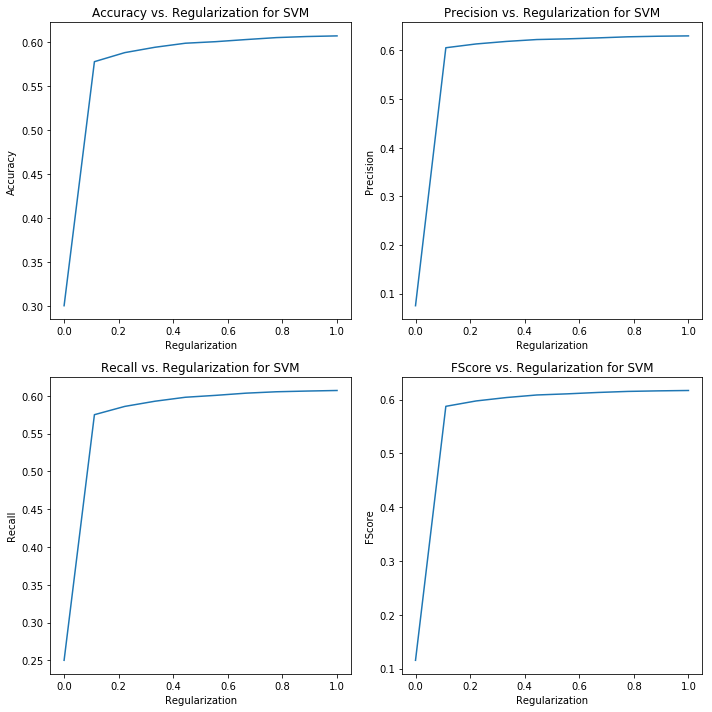

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Accuracy vs regularization
axes[0][0].plot(regs, accs, lw=1.5)
axes[0][0].set_xlabel('Regularization')
axes[0][0].set_ylabel('Accuracy')
axes[0][0].set_title('Accuracy vs. Regularization for SVM')

# Precision vs regularization
axes[0][1].plot(regs, precs, lw=1.5)
axes[0][1].set_xlabel('Regularization')
axes[0][1].set_ylabel('Precision')
axes[0][1].set_title('Precision vs. Regularization for SVM')

# Recall vs regularization
axes[1][0].plot(regs, recs, lw=1.5)
axes[1][0].set_xlabel('Regularization')
axes[1][0].set_ylabel('Recall')
axes[1][0].set_title('Recall vs. Regularization for SVM')

# FScore vs regularization
axes[1][1].plot(regs, fscores, lw=1.5)
axes[1][1].set_xlabel('Regularization')
axes[1][1].set_ylabel('FScore')
axes[1][1].set_title('FScore vs. Regularization for SVM')

# Adjust layout
fig.tight_layout()

Perform test on test set

In [30]:
print("SVM Accuracy: %0.2f%%" % (100 * top_model.score(x_test, y_test)))

SVM Accuracy: 61.81%


Compute confusion matrix, precision, recall and F-score with micro and macro averaging

In [31]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, top_model.predict(x_test))

measures_macro = list(precision_recall_fscore_support(y_test, top_model.predict(x_test), average='macro'))[:-1]
measures_micro = list(precision_recall_fscore_support(y_test, top_model.predict(x_test), average='micro'))[:-1]

Show the confusion matrix

In [32]:
cf_df = pd.DataFrame(cf, columns=['Predicted ilpt', 'Predicted lpt', 'Predicted slpt', 'Predicted ulpt'])
cf_df.rename(index={0:'ilpt',1:'lpt',2:'slpt',3:'ulpt'}, inplace=True)
cf_df

,Predicted ilpt,Predicted lpt,Predicted slpt,Predicted ulpt
ilpt,2081,259,322,659
lpt,221,6519,1798,1436
slpt,84,2049,5748,2061
ulpt,417,1617,1760,6181


Show precision, recall and F-score with averaging

In [33]:
measures_macro = ['macro'] + measures_macro
measures_micro = ['micro'] + measures_micro
measures_df = pd.DataFrame([measures_macro, measures_micro], columns=['Averaging', 'Precision', 'Recall', 'FScore'])
measures_df

,Averaging,Precision,Recall,FScore
0,macro,0.640391,0.619505,0.628553
1,micro,0.618120,0.618120,0.618120


#### Logistic Regression ####

Tune hyperparameters and retrieve measures

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

top_accuracy = 0;
top_reg = 0;

regs = np.linspace(1e-10, 0.05, 200)
accs = []
precs = []
recs = []
fscores = []

for reg in regs:
    lr_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=reg, max_iter=5000)
    lr_model.fit(x_train, y_train)
    acc = lr_model.score(x_validation, y_validation)
    accs.append(acc)
    measures = precision_recall_fscore_support(y_validation, lr_model.predict(x_validation), average='macro')
    precs.append(measures[0])
    recs.append(measures[1])
    fscores.append(measures[2])
    if acc > top_accuracy:
        top_accuracy = acc
        top_reg = reg

print("Top regularization:", top_reg)
print("Top accuracy:", top_accuracy)

# Retrain with whole training set and optimal penalty
top_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=top_reg, max_iter=10000)
top_model.fit(x_tv, y_tv);

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Top regularization: 0.048994974876381915
Top accuracy: 0.5622571609288877


Plot measures vs. penalty

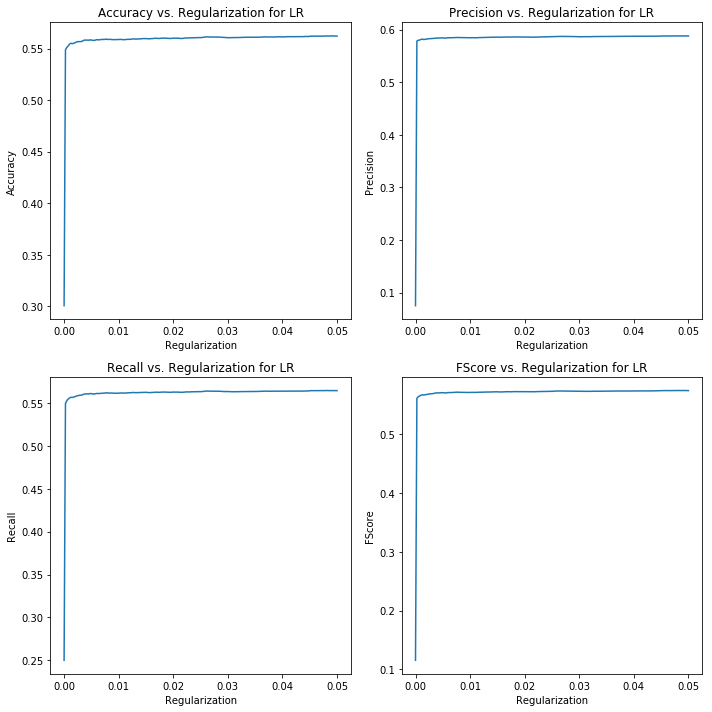

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Accuracy vs regularization
axes[0][0].plot(regs, accs, lw=1.5)
axes[0][0].set_xlabel('Regularization')
axes[0][0].set_ylabel('Accuracy')
axes[0][0].set_title('Accuracy vs. Regularization for LR')

# Precision vs regularization
axes[0][1].plot(regs, precs, lw=1.5)
axes[0][1].set_xlabel('Regularization')
axes[0][1].set_ylabel('Precision')
axes[0][1].set_title('Precision vs. Regularization for LR')

# Recall vs penalty
axes[1][0].plot(regs, recs, lw=1.5)
axes[1][0].set_xlabel('Regularization')
axes[1][0].set_ylabel('Recall')
axes[1][0].set_title('Recall vs. Regularization for LR')

# FScore vs regularization
axes[1][1].plot(regs, fscores, lw=1.5)
axes[1][1].set_xlabel('Regularization')
axes[1][1].set_ylabel('FScore')
axes[1][1].set_title('FScore vs. Regularization for LR')

# Adjust layout
fig.tight_layout()

Perform test on test set

In [36]:
print("LR Accuracy: %0.2f%%" % (100 * top_model.score(x_test, y_test)))

LR Accuracy: 57.05%


Compute confusion matrix, precision, recall and F-score with micro and macro averaging

In [37]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, top_model.predict(x_test))

measures_macro = list(precision_recall_fscore_support(y_test, top_model.predict(x_test), average='macro'))[:-1]
measures_micro = list(precision_recall_fscore_support(y_test, top_model.predict(x_test), average='micro'))[:-1]

Show the confusion matrix

In [38]:
cf_df = pd.DataFrame(cf, columns=['Predicted ilpt', 'Predicted lpt', 'Predicted slpt', 'Predicted ulpt'])
cf_df.rename(index={0:'ilpt',1:'lpt',2:'slpt',3:'ulpt'}, inplace=True)
cf_df

,Predicted ilpt,Predicted lpt,Predicted slpt,Predicted ulpt
ilpt,1942,339,273,767
lpt,215,6012,2080,1667
slpt,126,2285,5295,2236
ulpt,420,1791,2066,5698


Show precision, recall and F-score with averaging

In [39]:
measures_macro = ['macro'] + measures_macro
measures_micro = ['micro'] + measures_micro
measures_df = pd.DataFrame([measures_macro, measures_micro], columns=['Averaging', 'Precision', 'Recall', 'FScore'])
measures_df

,Averaging,Precision,Recall,FScore
0,macro,0.597427,0.572837,0.583274
1,micro,0.570487,0.570487,0.570487


### Pretrained Word2Vec ###

I will be using **Google's Word2Vec** trained dictionary, which includes word vectors for a vocabulary of 3 million words.<br>
Each vector has 300 features.

http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/

In [40]:
from gensim.models import Word2Vec, KeyedVectors

# Let's import the model
wv_ptrained = KeyedVectors.load_word2vec_format('pretrained/GoogleNews-vectors-negative300.bin', binary=True)

Even if the pretrained dictionary is large, we discovered that is does not contain some words.<br>
Hence, we will redefine the `sen2emb(sentences, word_dict)` function so that it accepts an undefined amount of dictionaries instead of a unique one $\rightarrow$ `sen2emb(sentences, *word_dicts)`.<br>
**Note:** all of them should return vectors with the same amount of dimensions.

This way, for every token, we will try to find a vector in the first dictionary. If it is not found, then we will try the second, etc.

In [41]:
def sen2emb(sentence, *word_dicts):
    """Transform a tokenized sentence into an embedding by adding the embedding word vectors."""
    embeddings = []
    for token in sentence:
        for word_dict in word_dicts:
            if token in word_dict.vocab:
                embeddings.append(word_dict[token].tolist())
                break
    embedding = sum_lists(embeddings)
    return embedding

Thus, we need (at least) a backup model. I will be using the **Wikipedia 2014 + Gigaword 5**, which has 300D vectors and 400k vocabulary size.<br>
It was extracted from https://nlp.stanford.edu/projects/glove/

As a side note, this `.txt` file is in GloVe format. Hence, we need to convert it to `Word2Vec` format.<br>
**Note:** loading a `.bin` file is much faster...

In [42]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Transform into w2v format
glove_file = 'pretrained/glove.6B.300d.txt'
tmp_file = 'pretrained/w2v_glove.6B.300d.txt'
glove2word2vec(glove_file, tmp_file)

# Import the backup model
wv_backup = KeyedVectors.load_word2vec_format(tmp_file, binary=False)

We will also train a new model using all the questions and a vector of length 300, in order to use it as a **last resource**.

In [43]:
# Train the second backup model
w2v_model = Word2Vec(sentences, min_count=1, size=300, window=10)

Let's generate a new $x$ using the new Word2Vec pretrained models.

In [44]:
x_train = [sen2emb(sub, wv_ptrained, wv_backup, w2v_model.wv) for sub in sub_train]
x_validation = [sen2emb(sub, wv_ptrained, wv_backup, w2v_model.wv) for sub in sub_validation]
x_tv = np.concatenate((x_train, x_validation), axis=0)
x_test = [sen2emb(sub, wv_ptrained, wv_backup, w2v_model.wv) for sub in sub_test]

Generate the labels for training, validation and testing

In [45]:
y_train = df_train['label'].values
y_validation = df_validation['label'].values
y_tv = np.concatenate((y_train, y_validation), axis=0)
y_test = df_test['label'].values

Standarize $x$ for training, validation and testing

In [46]:
x_train = standarize(x_train)
x_validation = standarize(x_validation)
x_tv = standarize(x_tv)
x_test = standarize(x_test)

#### Logistic Regression ####

Tune hyperparameters and retrieve measures

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

top_accuracy = 0;
top_reg = 0;

regs = np.linspace(1e-10, 0.05, 200)
accs = []
precs = []
recs = []
fscores = []

for reg in regs:
    lr_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=reg, max_iter=5000)
    lr_model.fit(x_train, y_train)
    acc = lr_model.score(x_validation, y_validation)
    accs.append(acc)
    measures = precision_recall_fscore_support(y_validation, lr_model.predict(x_validation), average='macro')
    precs.append(measures[0])
    recs.append(measures[1])
    fscores.append(measures[2])
    if acc > top_accuracy:
        top_accuracy = acc
        top_reg = reg

print("Top regularization:", top_reg)
print("Top accuracy:", top_accuracy)

# Retrain with whole training set and optimal penalty
top_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=top_reg, max_iter=10000)
top_model.fit(x_tv, y_tv);

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Top regularization: 0.015577889516080402
Top accuracy: 0.5729194903767959


Plot measures vs. penalty

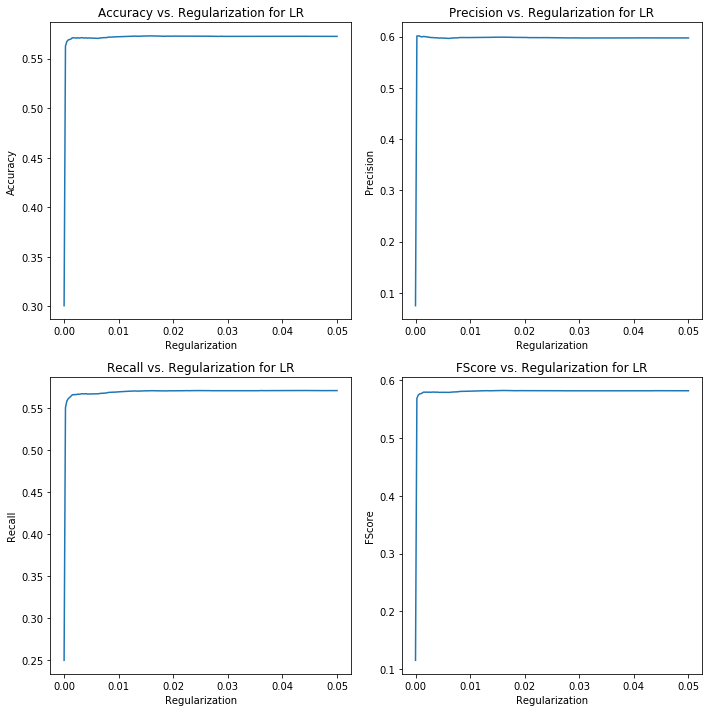

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# Accuracy vs regularization
axes[0][0].plot(regs, accs, lw=1.5)
axes[0][0].set_xlabel('Regularization')
axes[0][0].set_ylabel('Accuracy')
axes[0][0].set_title('Accuracy vs. Regularization for LR')

# Precision vs regularization
axes[0][1].plot(regs, precs, lw=1.5)
axes[0][1].set_xlabel('Regularization')
axes[0][1].set_ylabel('Precision')
axes[0][1].set_title('Precision vs. Regularization for LR')

# Recall vs penalty
axes[1][0].plot(regs, recs, lw=1.5)
axes[1][0].set_xlabel('Regularization')
axes[1][0].set_ylabel('Recall')
axes[1][0].set_title('Recall vs. Regularization for LR')

# FScore vs regularization
axes[1][1].plot(regs, fscores, lw=1.5)
axes[1][1].set_xlabel('Regularization')
axes[1][1].set_ylabel('FScore')
axes[1][1].set_title('FScore vs. Regularization for LR')

# Adjust layout
fig.tight_layout()

Perform test on test set

In [49]:
print("LR Accuracy: %0.2f%%" % (100 * top_model.score(x_test, y_test)))

LR Accuracy: 57.51%


Compute confusion matrix, precision, recall and F-score with micro and macro averaging

In [50]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, top_model.predict(x_test))

measures_macro = list(precision_recall_fscore_support(y_test, top_model.predict(x_test), average='macro'))[:-1]
measures_micro = list(precision_recall_fscore_support(y_test, top_model.predict(x_test), average='micro'))[:-1]

Show the confusion matrix

In [51]:
cf_df = pd.DataFrame(cf, columns=['Predicted ilpt', 'Predicted lpt', 'Predicted slpt', 'Predicted ulpt'])
cf_df.rename(index={0:'ilpt',1:'lpt',2:'slpt',3:'ulpt'}, inplace=True)
cf_df

,Predicted ilpt,Predicted lpt,Predicted slpt,Predicted ulpt
ilpt,1846,319,246,910
lpt,195,6088,1903,1788
slpt,140,2254,5313,2235
ulpt,400,1744,1979,5852


Show precision, recall and F-score with averaging

In [52]:
measures_macro = ['macro'] + measures_macro
measures_micro = ['micro'] + measures_micro
measures_df = pd.DataFrame([measures_macro, measures_micro], columns=['Averaging', 'Precision', 'Recall', 'FScore'])
measures_df

,Averaging,Precision,Recall,FScore
0,macro,0.601423,0.571827,0.583754
1,micro,0.575063,0.575063,0.575063
